<p align="center">
<img src="figures/UNIPD.png"  width="600"/> </p>
<p align="center">

<div align="center"> <h1 align="center"> UNIVERSITÀ DEGLI STUDI DI PADOVA  </h1> </div>
<div align="center"> <h2 align="center"> Dipartimento di Fisica e Astronomia “Galileo Galilei”</h2> </div>
<div align="center"> <h2 align="center"> Master degree in Physics of Data</h2> </div>
<div align="center"> <h2 align="center"> Course: Laboratory of Computational Physics, module A </h2> </div>

# ***Volatility carry trading strategy***

## Students:
    - Amjadi Bahador,
    - Attar Aidin, 2048654
    - Baci Ema,
    - Keshavarzmirzamohammadi Melika

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd

import numpy.random as npr

from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from scipy import optimize
from scipy import stats
from scipy import integrate

#import QuantLib as ql
import copy

npr.seed(12345)

%matplotlib inline

Table of content:
- [Theoretical introduction](#intro)
    - [What are Options?](#options)
- 


## **Theoretical introduction** <a class="anchor" id="intro"></a>
In this section, we make a theoretical introduction about the basic concepts needed in order to understand the project.

### **What are Options?** <a class="anchor" id="options"></a>

Options are contracts that give the bearer the right, but not the obligation, to either buy or sell an amount of some underlying asset at a predetermined price at or before the contract expires.

Depending on the situation, there is usually an option scenario appropriate for an investor’s goal. A popular example would be using options as an effective hedge against a declining stock market to limit downside losses.\
Options belong to the larger group of securities known as derivatives. A derivative's price is dependent on or derived from the price of something else.

#### **Call and Put Options**

Options are a type of derivative security. An option is a derivative because its price is intrinsically linked to the price of something else. If you buy an options contract, it grants you the right but not the obligation to buy or sell an underlying asset at a set price on or before a certain date.

A call option gives the holder the right to buy a stock and a put option gives the holder the right to sell a stock. Think of a call option as a down payment on a future purchase and a put option as an insurance policy.

There are four things you can do with options:

    1. Buy (long) calls
    2. Sell (short) calls
    3. Buy (long) puts
    4. Sell (short) puts
Buying stock gives you a long position. Buying a call option gives you a potential long position in the underlying stock. Short-selling a stock gives you a short position. Selling a naked or uncovered call gives you a potential short position in the underlying stock.

Buying a put option gives you a potential short position in the underlying stock. Selling a naked or unmarried put gives you a potential long position in the underlying stock. Keeping these four scenarios straight is crucial.

People who buy options are called holders and those who sell options are called writers of options.

In [2]:
dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'

UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')
UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')

UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)

UX1

,PX_LAST,PX_VOLUME
Date,,
2010-01-04,24.8500,3138
2010-01-05,24.4500,1936
2010-01-06,23.5500,1958
2010-01-07,23.1500,1760
2010-01-08,22.5500,2050
...,...,...
2022-01-12,20.9713,76675
2022-01-13,22.0944,82700
2022-01-14,21.7462,102849


Historical data of SPX price found at https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

In [3]:
file_name         = 'SPX_HistoricalData.csv'
SPX_price         = pd.read_csv(dir+file_name)
SPX_price['Date'] = pd.to_datetime(SPX_price['Date'],format='%m/%d/%y')
SPX_price         = SPX_price.set_index('Date')
SPX_price.sort_index(inplace=True)
SPX_price

,Open,High,Low,Close
Date,,,,
2010-04-01,1171.23,1181.43,1170.69,1178.10
2010-04-05,1178.71,1187.73,1178.71,1187.44
2010-04-06,1186.01,1191.80,1182.77,1189.44
2010-04-07,1188.23,1189.60,1177.25,1182.45
2010-04-08,1181.75,1188.55,1175.12,1186.44
...,...,...,...,...
2022-01-10,4655.34,4673.02,4582.24,4670.29
2022-01-11,4669.14,4714.13,4638.27,4713.07
2022-01-12,4728.59,4748.83,4706.71,4726.35


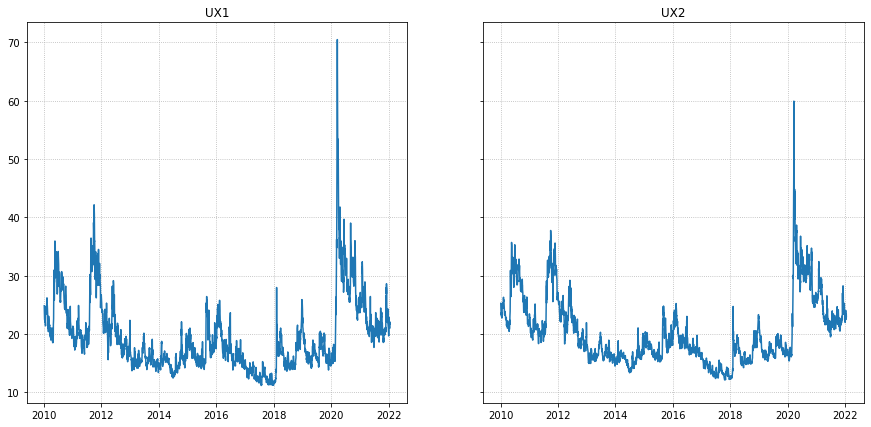

In [4]:
fig,ax = plt.subplots(ncols=2, figsize=(15,7), sharey=True)
ax[0].plot(UX1.index, UX1.PX_LAST)
ax[1].plot(UX2.index, UX2.PX_LAST)
ax[0].set_title('UX1')
ax[1].set_title('UX2')
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
plt.show()

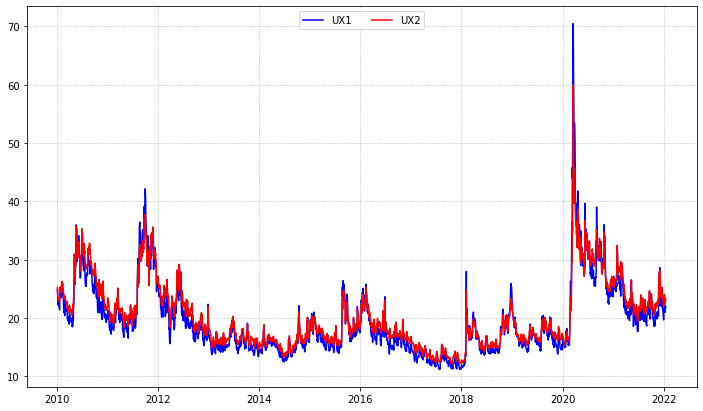

In [5]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax.plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax.legend(loc='upper center', ncol=2)
ax.grid(linestyle='dotted')
plt.show()

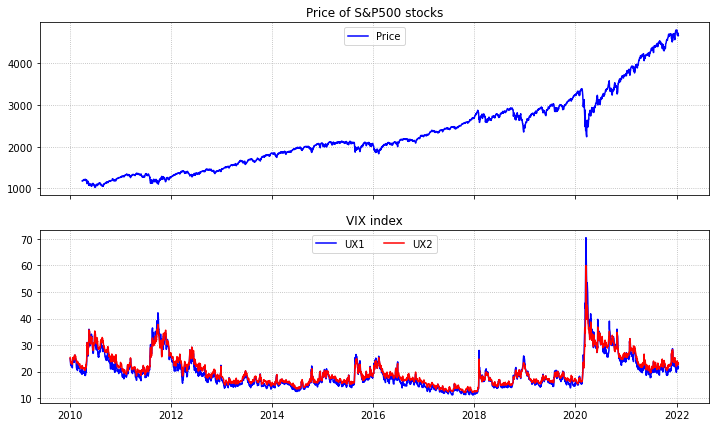

In [6]:
fig,ax = plt.subplots(nrows=2,figsize=(12,7), sharex=True)
ax[0].plot(SPX_price.index, SPX_price.Close, label='Price', color='blue')
ax[0].legend(loc='upper center', ncol=2)
ax[0].grid(linestyle='dotted')
ax[0].set_title('Price of S&P500 stocks')

ax[1].plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax[1].plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax[1].legend(loc='upper center', ncol=2)
ax[1].grid(linestyle='dotted')
ax[1].set_title('VIX index')
plt.show()

## Heston Model

In [7]:
start     = '2010-04-05'
stop      = '2022-01-14'
mask      = ( UX1.index       >= start ) & ( UX1.index       < stop )
UX1       =   UX1[      mask]
mask      = ( UX2.index       >= start ) & ( UX2.index       < stop )
UX2       =   UX2[      mask]
mask      = ( SPX_price.index >= start ) & ( SPX_price.index < stop )
SPX_price =   SPX_price[mask]

UX1       = UX1.drop(UX1.drop(SPX_price.index).index)
UX1       = UX2.drop(UX2.drop(SPX_price.index).index)

In [8]:
def heston_pde_euler( S_0,   T,     r,     k,  theta,
                      v_0, rho, sigma, steps, Npaths ):
    dt         = T / steps
    size       = ( Npaths, steps )
    prices     = np.zeros(         size )
    volatility = np.zeros(         size )
    S_t        = np.full ( Npaths,  S_0 )
    v_t        = np.full ( Npaths,  v_0 )
    for t in range( steps ):
        WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=Npaths )

        S_t = S_t +              r * S_t                   * dt + S_t   * np.sqrt( v_t ) * WT[:, 0]
        #S_t = S_t * np.exp( (    r - 0.5           * v_t ) * dt +         np.sqrt( v_t ) * WT[:, 0] )
        v_t =       np.abs(    v_t +   k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT[:, 1] )

        prices[    :,t] = S_t
        volatility[:,t] = v_t

    return prices, volatility

In [9]:
def heston_pde_milstein( S_0,   T,     r,     k,  theta,
                         v_0, rho, sigma, steps, Npaths ):
    dt         = T / steps
    size       = ( Npaths, steps )
    prices     = np.zeros(         size )
    volatility = np.zeros(         size )
    S_t        = np.full ( Npaths,  S_0 )
    v_t        = np.full ( Npaths,  v_0 )
    for t in range( steps ):
        WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=Npaths )

        #S_t = S_t +              r * S_t                   * dt + S_t   * np.sqrt( v_t ) * WT[:, 0] + .25 *   S_t**2 * ( WT[:,0]**2 - dt )
        #S_t = S_t * np.exp( (    r - 0.5           * v_t ) * dt +         np.sqrt( v_t ) * WT[:, 0] )
        S_t =       np.log( S_t ) + ( r - 0.5  * v_t ) * dt + np.sqrt( v_t ) * WT[:, 0]
        v_t =       np.abs(    v_t +   k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT[:, 1] + .25 * sigma**2 * ( WT[:,1]**2 - dt ) )

        prices[    :, t] = S_t
        volatility[:, t] = v_t

    return prices, volatility

In [10]:
def r_comp(S, v, dt, N, rho):
    r  = np.empty( ( N, S.size ) )
    WT = np.random.normal( 0, 1, N )

    for t in range( 0, S.size-1 ):
        r[:, t]  = v[t] / 2 + np.log( S[t+1] / S[t] ) / dt - np.sqrt( v[t] / dt ) * WT[0]
        #r[:, t]  = v[t] / 2 + np.log( S[t+1] / S[t] ) / dt
        #r[:, t]  = ( S[t+1] / S[t] - 1 ) / dt #- np.sqrt( v[t] / dt ) * WT[:]
        #r[:, t]  = ( S[t+1] / S[t] - 1 ) / dt - np.sqrt( v[t] / dt ) * WT[0] - S[t] * ( WT[0]**2 - 1 ) / 4
        #r[:, t]  = ( S[t+1] / S[t] - 1 ) / dt
        #r[:, t]  = ( S[t+1] / S[t] - 1 ) / dt - np.sqrt( v[t] / dt ) * 0 - S[t] * ( 1 - 1 ) / 4
        #print( ( S[t+1] / S[t] - 1 ) / dt - np.sqrt( v[t] / dt )* WT[:, 0].mean() - S[t] * ( (WT[:, 0]**2).mean() - 1 ) / 4 )
    r[:, t+1] = r[:, t]
    return r.mean( axis=0 )

In [11]:
T       = 1
steps   = 1
Npaths  = 100
delta   = T / steps

rho     = -.7890 # don't know how to find it
#rt      = 100000   # don't know how to find it
r       = r_comp(SPX_price.Close.values, UX1.PX_LAST.values**2, delta, 1000, rho)
n       = 20

prices1 = np.empty( ( SPX_price.index.size - n, Npaths ) )
prices2 = np.empty( ( SPX_price.index.size - n, Npaths ) )
vol1    = np.empty( (       UX1.index.size - n, Npaths ) )
vol2    = np.empty( (       UX2.index.size - n, Npaths ) )

for i in range(n,UX1.index.size):
    Vt1             = UX1.PX_LAST.iloc[    i-n:i].values**2
    Vt2             = UX2.PX_LAST.iloc[    i-n:i].values**2
    S               = SPX_price.Close.iloc[i-n:i].values
    rt              = r[i-1]

    S0              = S[  -1]
    V10             = Vt1[-1]
    V20             = Vt2[-1]

    P1              = ( ( 1 / n    * sum( ( Vt1[i] * Vt1[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt1[i] / Vt1[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) )
    P2              = ( ( 1 / n    * sum( ( Vt2[i] * Vt2[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt2[i] / Vt2[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) )

    k1              = 2 / delta * (1 + P1 * delta / ( 2 * n ) * sum(        1 / Vt1[i-1]        for i in range( 1, n ) ) -
                                   1 / n  *                     sum( ( Vt1[i] / Vt1[i-1] )**0.5 for i in range( 1, n ) ) )
    k2              = 2 / delta * (1 + P2 * delta / ( 2 * n ) * sum(        1 / Vt2[i-1]        for i in range( 1, n ) ) -
                                   1 / n  *                     sum( ( Vt2[i] / Vt2[i-1] )**0.5 for i in range( 1, n ) ) )

    sigma1          = ( 4 / ( delta * n ) * sum( Vt1[i]**.5 - Vt1[i-1]**.5 - delta /
                      ( 2 * Vt1[i-1]**.5 ) *( P1 - k1 * Vt1[i-1] ) for i in range( 1, n ) ) )**.5
    sigma2          = ( 4 / ( delta * n ) * sum( Vt2[i]**.5 - Vt2[i-1]**.5 - delta /
                      ( 2 * Vt2[i-1]**.5 ) *( P2 - k2 * Vt2[i-1] ) for i in range( 1, n ) ) )**.5

    theta1          = ( P1 + sigma1**2 / 2 ) / k1
    theta2          = ( P2 + sigma2**2 / 2 ) / k2

    #p1, v1          = heston_pde_euler( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    #p2, v2          = heston_pde_euler( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )
    p1, v1          = heston_pde_milstein( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    p2, v2          = heston_pde_milstein( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )


    vol1[   i-n,:] = v1[:].ravel( )
    vol2[   i-n,:] = v2[:].ravel( )
    prices1[i-n,:] = p1[:].ravel( )
    prices2[i-n,:] = p2[:].ravel( )

In [12]:
vol1    = np.insert( vol1,    0, np.full( ( n, Npaths ), np.nan ), axis=0 )
vol2    = np.insert( vol2,    0, np.full( ( n, Npaths ), np.nan ), axis=0 )
prices1 = np.insert( prices1, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )
prices2 = np.insert( prices2, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )

for k in range(Npaths):
    col_vol  = 'sim_'   + str( k )
    col_pr1  = 'sim_1_' + str( k )
    col_pr2  = 'sim_2_' + str( k )
    UX1[      col_vol] = pd.Series( np.sqrt(   vol1[:,k] ), index =       UX1.index )
    UX2[      col_vol] = pd.Series( np.sqrt(   vol2[:,k] ), index =       UX2.index )
    SPX_price[col_pr1] = pd.Series( prices1[:,k], index = SPX_price.index )
    SPX_price[col_pr2] = pd.Series( prices2[:,k], index = SPX_price.index )


UX1[      'mean_sim' ] = ( UX1.loc[      :, ['sim_'   + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )
UX2[      'mean_sim' ] = ( UX2.loc[      :, ['sim_'   + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )
SPX_price['mean_sim1'] = ( SPX_price.loc[:, ['sim_1_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )
SPX_price['mean_sim2'] = ( SPX_price.loc[:, ['sim_2_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )

/tmp/ipykernel_175828/3364036119.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_price[col_pr1] = pd.Series( prices1[:,k], index = SPX_price.index )
/tmp/ipykernel_175828/3364036119.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_price[col_pr2] = pd.Series( prices2[:,k], index = SPX_price.index )
/tmp/ipykernel_175828/3364036119.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

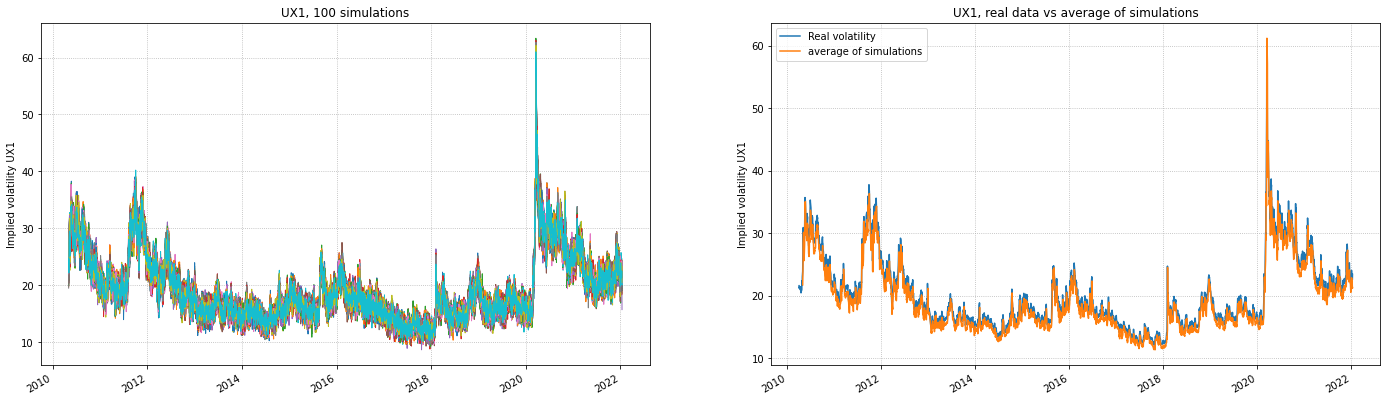

In [13]:
fig, ax = plt.subplots( ncols=2, figsize=( 24, 7 ) )

#ax[0].plot(UX1.index, UX1.PX_LAST, lw=2, label='Real volatility')
for k in range( Npaths ):
    col = 'sim_' + str(k)
    ax[0].plot( UX1.index, UX1[col], label='', lw=1 )
ax[0].grid( linestyle='dotted' )
#ax[0].legend(loc='upper left')
ax[0].set_title ( 'UX1, ' + str( Npaths ) + ' simulations' )
ax[0].set_ylabel( 'Implied volatility UX1' )

ax[1].plot( UX1.index, UX1.PX_LAST, label='Real volatility')
ax[1].plot( UX1.index, UX1['mean_sim'], label='average of simulations' )
ax[1].grid( linestyle='dotted')
ax[1].legend( loc='upper left')
ax[1].set_title ( 'UX1, real data vs average of simulations')
ax[1].set_ylabel( 'Implied volatility UX1')

fig.autofmt_xdate( )
plt.show()

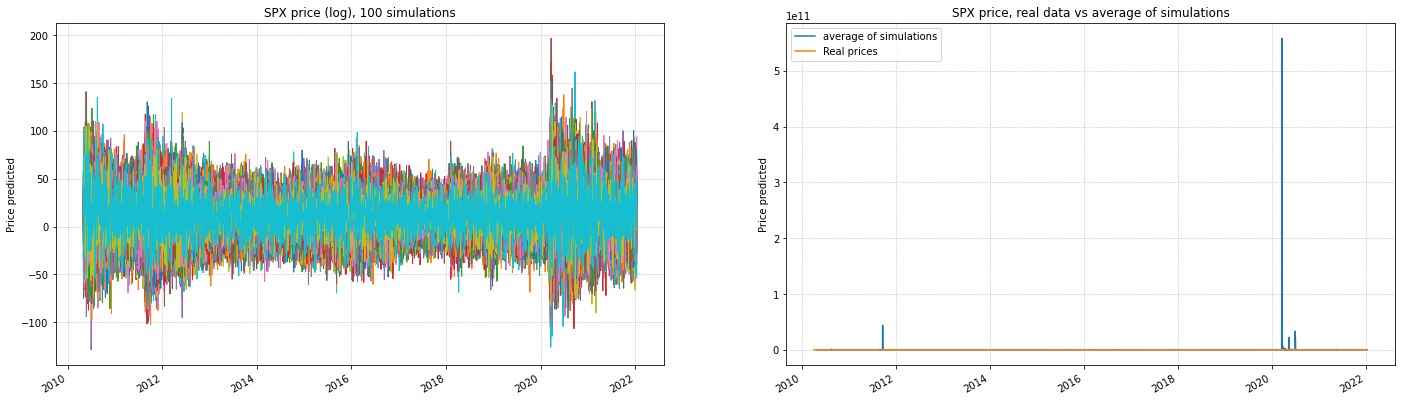

In [14]:
fig, ax = plt.subplots( ncols=2, figsize=( 24, 7 ) )

#ax[0].plot(UX1.index, UX1.PX_LAST, lw=2, label='Real volatility')
for k in range( Npaths ):
    col = 'sim_1_' + str(k)
    ax[0].plot( SPX_price.index, SPX_price[col], label='', lw=1 )
ax[0].grid( linestyle='dotted' )
#ax[0].legend(loc='upper left')
ax[0].set_title ( 'SPX price (log), ' + str( Npaths ) + ' simulations' )
ax[0].set_ylabel( 'Price predicted' )

ax[1].plot( SPX_price.index, np.exp(SPX_price['mean_sim1']), label='average of simulations' )
ax[1].plot( SPX_price.index, SPX_price.Close, label='Real prices')
ax[1].grid( linestyle='dotted')
ax[1].legend( loc='upper left')
ax[1].set_title ( 'SPX price, real data vs average of simulations')
ax[1].set_ylabel( 'Price predicted')

fig.autofmt_xdate( )
plt.show()

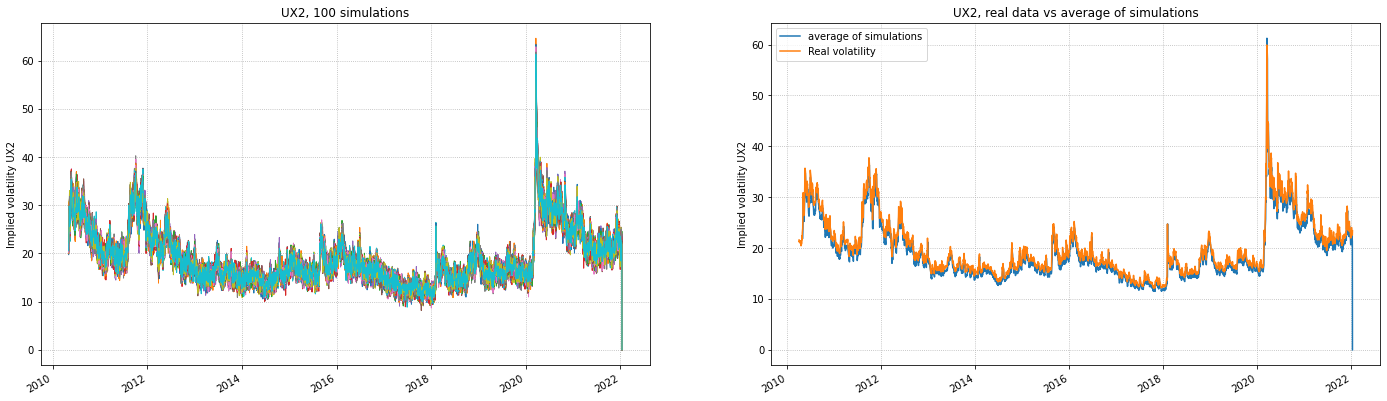

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    col = 'sim_' + str(k)
    ax[0].plot(UX2.index, UX2[col], label='', lw=1)
#ax[0].plot(UX2.index, UX2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
#ax[0].legend(loc='best')
ax[0].set_title('UX2, ' + str(Npaths) + ' simulations')
ax[0].set_ylabel('Implied volatility UX2')

ax[1].plot(UX2.index, UX2['mean_sim'], label='average of simulations')
ax[1].plot(UX2.index, UX2.PX_LAST, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('UX2, real data vs average of simulations')
ax[1].set_ylabel('Implied volatility UX2')

fig.autofmt_xdate()
plt.show()

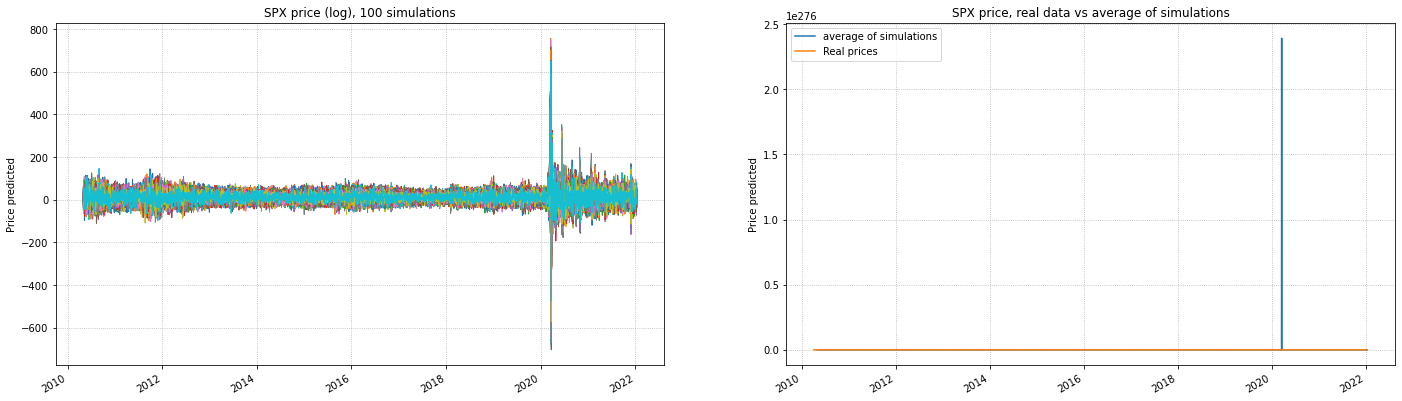

In [16]:
fig, ax = plt.subplots( ncols=2, figsize=( 24, 7 ) )

#ax[0].plot(UX1.index, UX1.PX_LAST, lw=2, label='Real volatility')
for k in range( Npaths ):
    col = 'sim_2_' + str(k)
    ax[0].plot( SPX_price.index, SPX_price[col], label='', lw=1 )
ax[0].grid( linestyle='dotted' )
#ax[0].legend(loc='upper left')
ax[0].set_title ( 'SPX price (log), ' + str( Npaths ) + ' simulations' )
ax[0].set_ylabel( 'Price predicted' )

ax[1].plot( SPX_price.index, np.exp(SPX_price['mean_sim2']), label='average of simulations' )
ax[1].plot( SPX_price.index, SPX_price.Close, label='Real prices')
ax[1].grid( linestyle='dotted')
ax[1].legend( loc='upper left')
ax[1].set_title ( 'SPX price, real data vs average of simulations')
ax[1].set_ylabel( 'Price predicted')

fig.autofmt_xdate( )
plt.show()

In [17]:
UX1[      'resid' ] =               UX1['mean_sim']    - UX1[      'PX_LAST']
UX2[      'resid' ] =               UX2['mean_sim']    - UX2[      'PX_LAST']
SPX_price['resid1'] = np.exp( SPX_price['mean_sim1'] ) - SPX_price['Close']
SPX_price['resid2'] = np.exp( SPX_price['mean_sim2'] ) - SPX_price['Close']

/tmp/ipykernel_175828/916437075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_price['resid1'] = np.exp( SPX_price['mean_sim1'] ) - SPX_price['Close']
/tmp/ipykernel_175828/916437075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_price['resid2'] = np.exp( SPX_price['mean_sim2'] ) - SPX_price['Close']


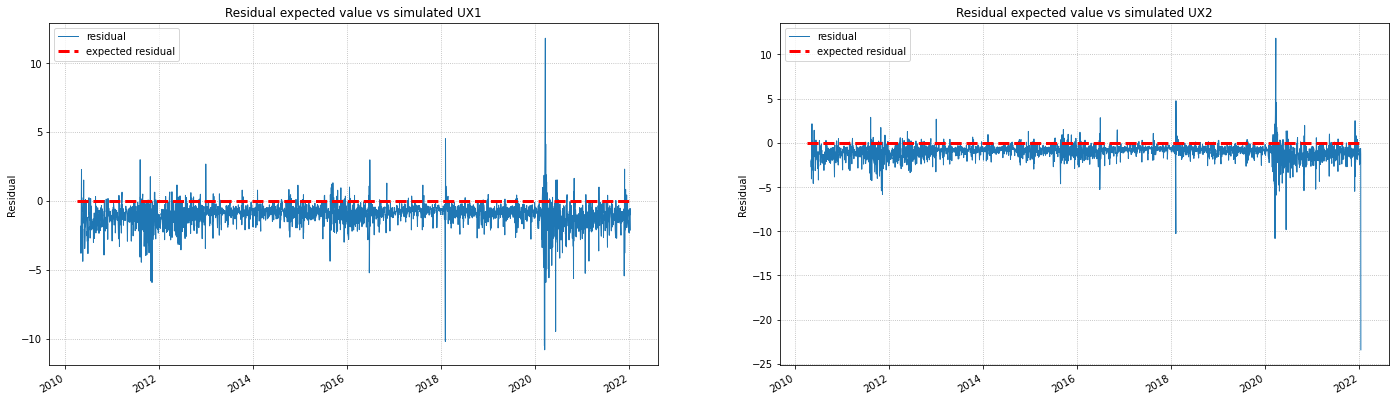

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

ax[0].plot(UX1.index, UX1.resid, lw=1, label='residual')
ax[0].hlines(0, UX1.index.min(), UX1.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[0].grid(linestyle='dotted')
ax[0].legend(loc='best')
ax[0].set_title('Residual expected value vs simulated UX1')
ax[0].set_ylabel('Residual')

ax[1].plot(UX2.index, UX2.resid, lw=1, label='residual')
ax[1].hlines(0, UX2.index.min(), UX2.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Residual expected value vs simulated UX2')
ax[1].set_ylabel('Residual')

fig.autofmt_xdate()
plt.show()

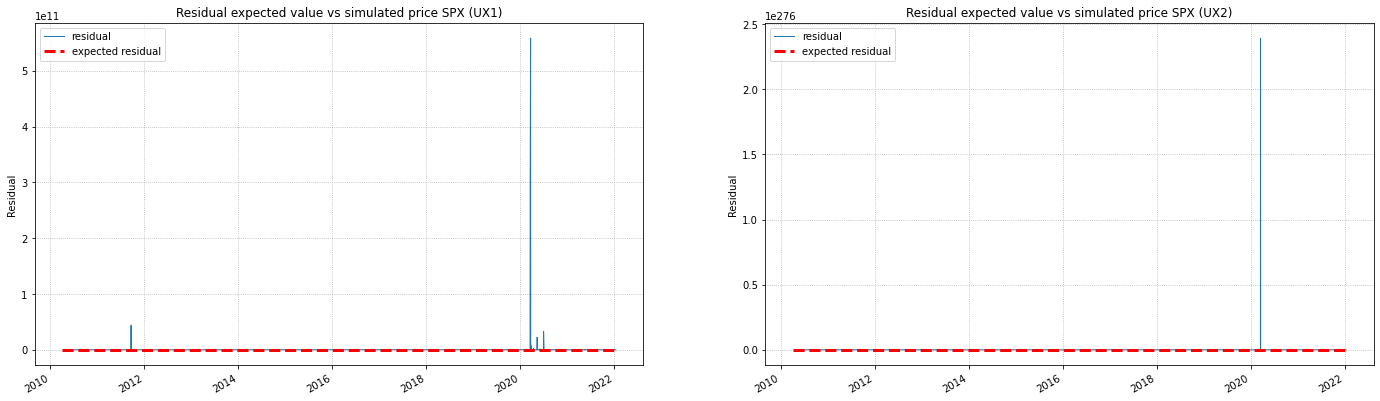

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

ax[0].plot(SPX_price.index, SPX_price.resid1, lw=1, label='residual')
ax[0].hlines(0, SPX_price.index.min(), SPX_price.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[0].grid(linestyle='dotted')
ax[0].legend(loc='best')
ax[0].set_title('Residual expected value vs simulated price SPX (UX1)')
ax[0].set_ylabel('Residual')

ax[1].plot(SPX_price.index, SPX_price.resid2, lw=1, label='residual')
ax[1].hlines(0, SPX_price.index.min(), SPX_price.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Residual expected value vs simulated price SPX (UX2)')
ax[1].set_ylabel('Residual')

fig.autofmt_xdate()
plt.show()

N  			=		 228.27726733154392 		+/-		 3.488380139282037
mu 			=		 -0.8260476285238442 		+/-		 0.008057797192241334
std			=		 0.4566443822611122 		+/-		 0.008057797171057764


R2 			=		 0.9634620834510134 
R 			=		 0.981561044179634

Covariance matrix:
 [[ 1.         -0.07146139]
 [-0.07146139  1.        ]]

n degrees of freedom 	=		 84

chi2 			=		 396.65532602478714
p-value 		=		 0.0


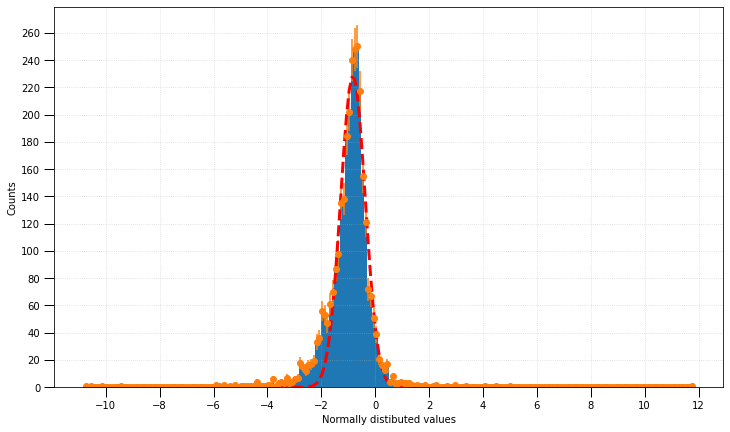

In [20]:
b                 = np.histogram_bin_edges(UX1.resid.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(UX1.resid, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_locator(MultipleLocator( 2))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,0, 1])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

N  			=		 229.96449614223417 		+/-		 2.9121924211662398
mu 			=		 -0.8280721223059347 		+/-		 0.006657963790940365
std			=		 0.455305894656928 		+/-		 0.00665796380666757


R2 			=		 0.9623613582729545 
R 			=		 0.9810001826059741

Covariance matrix:
 [[1.         0.11652218]
 [0.11652218 1.        ]]

n degrees of freedom 	=		 80

chi2 			=		 405.3271378815362
p-value 		=		 0.0


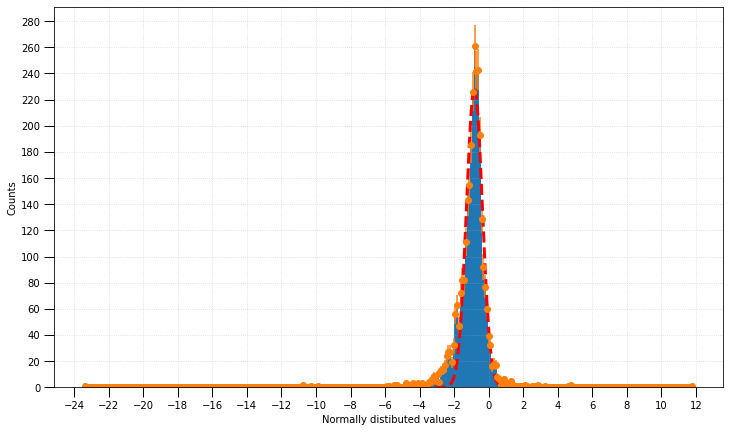

In [21]:
b                 = np.histogram_bin_edges(UX2.resid.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(UX2.resid, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_locator(MultipleLocator( 2))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,0, 1])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

KeyboardInterrupt: 

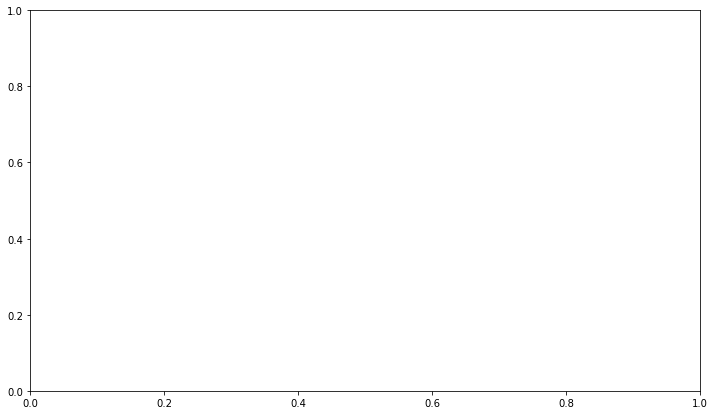

In [22]:
b                 = np.histogram_bin_edges(SPX_price.resid1.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(SPX_price.resid1, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(30))
#ax.xaxis.set_major_locator(MultipleLocator(50))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [300,0, 500])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

N  			=		 219.46370527523362 		+/-		 2.112368755230755
mu 			=		 -38.33717856020394 		+/-		 1.3028797818159414
std			=		 117.2283669099534 		+/-		 1.3028797717199017


R2 			=		 0.9890676274146396 
R 			=		 0.994518791886126

Covariance matrix:
 [[ 1.         -0.21331644]
 [-0.21331644  1.        ]]

n degrees of freedom 	=		 70

chi2 			=		 197.19635649876778
p-value 		=		 4.796163466380676e-14


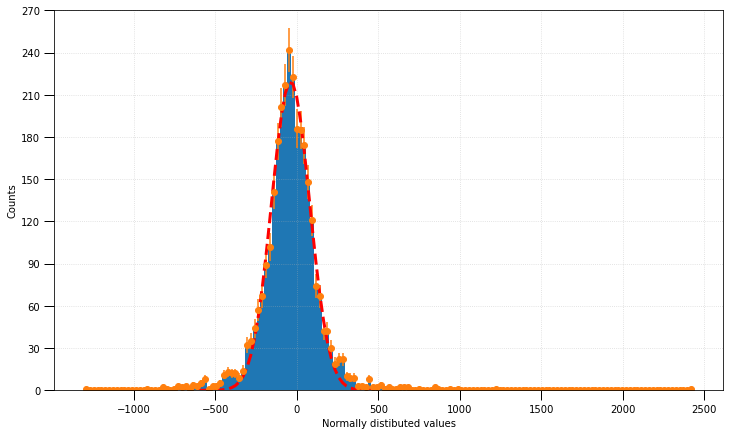

In [ ]:
b                 = np.histogram_bin_edges(SPX_price.resid2.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(SPX_price.resid2, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(30))
#ax.xaxis.set_major_locator(MultipleLocator(50))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [300,0, 500])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r', lw=3 )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err]**2)
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

Sistematic underestimation of volatility

Problems on prices (i get values without any sense)

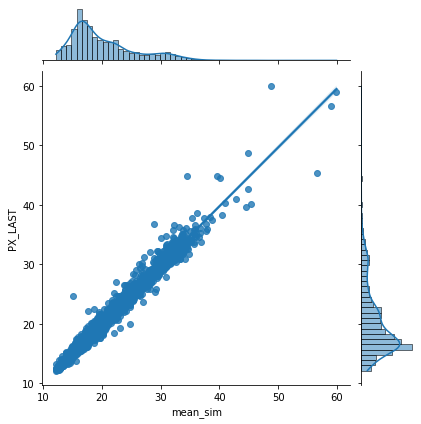

In [ ]:
sns.jointplot(x='mean_sim', y='PX_LAST', data=UX1, kind='reg')

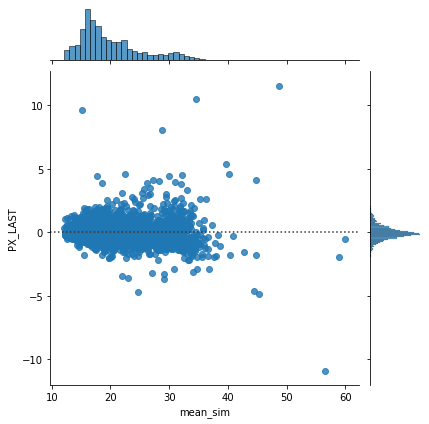

In [ ]:
sns.jointplot(x='mean_sim', y='PX_LAST', data=UX1, kind='resid')

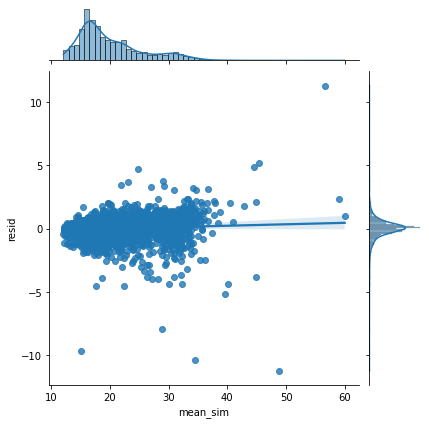

In [ ]:
sns.jointplot(x='mean_sim', y='resid', data=UX1, kind='reg')

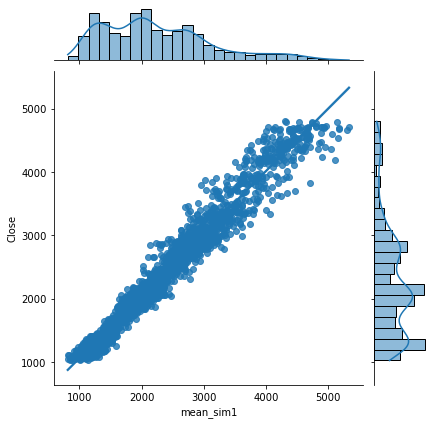

In [ ]:
sns.jointplot(x=np.exp(SPX_price['mean_sim1']), y=SPX_price['Close'], kind='reg')

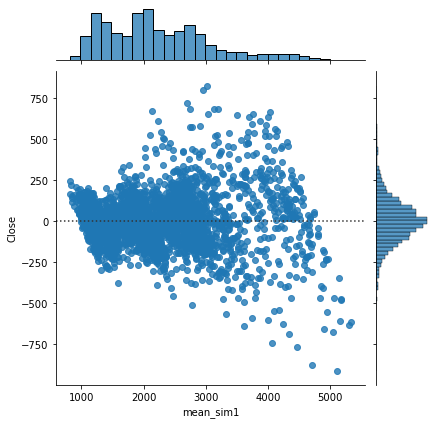

In [ ]:
sns.jointplot(x=np.exp(SPX_price['mean_sim1']), y=SPX_price['Close'], kind='resid')

In [ ]:
# characteristic function
def f( phi, kappa, theta, sigma,    rho,
        v0,     r,     T,    s0, status ):

    a = kappa * theta
    x = np.log( s0 )

    # remind that lamda is zero
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -.5
        b = kappa

    d = np.sqrt( (   rho * sigma * phi * 1j - b )**2 - sigma**2 * ( 2 * u * phi * 1j - phi**2 ) )
    g =        ( b - rho * sigma * phi * 1j + d)     / (b - rho   * sigma * phi * 1j -      d   )

    C = ( r * phi * 1j * T + ( a / sigma**2 ) * ( ( b - rho * sigma * phi * 1j + d ) *
          T - 2 * np.log( ( 1 - g * np.exp( d * T ) ) / ( 1 - g ) ) ) )
    D = ( b - rho * sigma * phi * 1j + d ) / ( sigma**2 ) * ( ( 1 - np.exp( d * T ) ) / ( 1 - g * np.exp( d * T ) ) )

    return np.exp( C + D * v0 + 1j * phi * x )

# P1 and P2
def p( kappa, theta, sigma, rho, v0, r, T, s0, K, status ):
    integrand = lambda phi: ( np.exp( -1j * phi * np.log( K ) ) *
                              f( phi, kappa, theta, sigma, rho, v0, r, T, s0, status ) / ( 1j * phi ) ).real

    return ( 0.5 + ( 1 / np.pi ) * integrate.quad( integrand, 0, 100 )[0] ) # approximate indefinite intergral with a definite one

def p1(       kappa, theta, sigma, rho, v0, r, T, s0, K    ):
    return p( kappa, theta, sigma, rho, v0, r, T, s0, K, 1 )

def p2(       kappa, theta, sigma, rho, v0, r, T, s0, K    ):
    return p( kappa, theta, sigma, rho, v0, r, T, s0, K, 2 )

# call price
def call_price( kappa, theta, sigma, rho, v0, r, T, s0, K ):
    P1 = p1( kappa, theta, sigma, rho, v0, r, T, s0, K )
    P2 = p2( kappa, theta, sigma, rho, v0, r, T, s0, K )
    print(P1, P2)
    result = ( s0 * P1 - K * np.exp( -r * T ) * P2 )

    if result < 0 or k - s0 > 1: # negative result or initial price very very low with respect to k
        result = 0

    return result

In [ ]:
T       = 1
steps   = 1
Npaths  = 100
delta   = T / steps

rho     = -.7890 # don't know how to find it
#r       = 2.17   # don't know how to find it
r       = r_comp(SPX_price.Close.values, UX1.PX_LAST.values**2, delta, 1000, rho)
n       = 30

call_prices = np.empty( ( UX1.index.size - n, Npaths ) )

for i in range(n,UX1.index.size):
    Vt1             = UX1.PX_LAST.iloc[    i-n:i].values**2
    Vt2             = UX2.PX_LAST.iloc[    i-n:i].values**2
    S               = SPX_price.Close.iloc[i-n:i].values
    rt              = r[i]

    S0              = S[  -1]
    V10             = Vt1[-1]
    V20             = Vt2[-1]

    P_1             = ( ( 1 / n    * sum( ( Vt1[i] * Vt1[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt1[i] / Vt1[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) )
    P_2             = ( ( 1 / n    * sum( ( Vt2[i] * Vt2[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt2[i] / Vt2[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) )

    k1              = 2 / delta * (1 + P_1 * delta / ( 2 * n ) * sum(        1 / Vt1[i-1]        for i in range( 1, n ) ) -
                                   1 / n   *                     sum( ( Vt1[i] / Vt1[i-1] )**0.5 for i in range( 1, n ) ) )
    k2              = 2 / delta * (1 + P_2 * delta / ( 2 * n ) * sum(        1 / Vt2[i-1]        for i in range( 1, n ) ) -
                                   1 / n   *                     sum( ( Vt2[i] / Vt2[i-1] )**0.5 for i in range( 1, n ) ) )

    sigma1          = ( 4 / ( delta * n ) * sum( Vt1[i]**.5 - Vt1[i-1]**.5 - delta /
                      ( 2 * Vt1[i-1]**.5 ) *( P_1 - k1 * Vt1[i-1] ) for i in range( 1, n ) ) )**.5
    sigma2          = ( 4 / ( delta * n ) * sum( Vt2[i]**.5 - Vt2[i-1]**.5 - delta /
                      ( 2 * Vt2[i-1]**.5 ) *( P_2 - k2 * Vt2[i-1] ) for i in range( 1, n ) ) )**.5

    theta1          = ( P_1 + sigma1**2 / 2 ) / k1
    theta2          = ( P_2 + sigma2**2 / 2 ) / k2

    P_1              = call_price( k1, theta1, sigma1, rho, V10, rt, T, S0, 100 )
    #P_1, v1          = heston_pde_milstein( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    #P_2, v2          = heston_pde_milstein( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )


    call_prices[i-n,:] = P_1.ravel( )

[242.03393638 233.30428068 237.65458279 ... 263.39125431 263.20654832
 263.20654832]
1.0000000000073774 0.8196008973891025
0.9999999999948274 0.9661250851201145
0.9999999999993695 0.9193379719095685
0.9999999999999963 0.9994116648284818
0.9999999999459308 0.6943353001794654
0.9999999999136224 0.5334607523573768
1.0000000000640004 0.4241208543687396
1.0000000001155995 0.48167970026108664
0.9999999999999896 0.13099300854615692
1.0000000000005271 0.7906571171551594
1.0000000000002542 0.8176523754907545
0.999999999999851 0.37576193685771353
0.9999999999979254 0.6440040842059412
1.0000000000036107 0.9728311380939387
1.0000000000002642 0.8804276742619878
1.0000000000000526 0.4436954078594584
0.999999999999561 0.8106199301296266
0.9999999999999847 0.3476600225845054
1.0000000000008735 0.5801530899406685
0.9999999999989396 0.6566625968636821
1.0000000000013842 0.36405518980893475
1.000000000036147 0.6728750807492461
1.000000000075798 0.6513580481474558
0.9999999998881822 0.5991944222325866
1.0

/tmp/ipykernel_98504/2479361839.py:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return ( 0.5 + ( 1 / np.pi ) * integrate.quad( integrand, 0, 100 )[0] ) # approximate indefinite intergral with a definite one


0.9999999999877887 0.49999999997290573
1.000000000000861 0.5000000000001488
0.9999999999775471 0.5
0.999999999960076 0.5
0.9999999998340813 0.5
0.9999999999999636 0.4999999999687608
0.9999999999828868 0.9998146032427925
1.0000000000000555 0.5000000000493927
0.9999999999927978 0.9999859817859882
1.0000000000002292 0.500000000033413
0.9999999999997357 0.5000000008733445
1.0000000000003952 0.46286736880530116
0.9999999999998712 0.13085634534815038
0.9999999999998188 0.5248818007616148
0.9999999999933137 0.1524768839548868
0.9999999999398766 0.8528183976305597
0.99999999999192 0.517940734010992
0.9999999999714189 0.3188804283213576
1.0000000002955716 0.47986376756671806
0.9999999999999772 0.2316579394686658
0.9999999999989342 0.9904492346556416
1.000000000352363 0.6593886142827776
0.9999999999999432 0.3524255118201526
1.0000000000002662 0.9974711538431029
0.9999999993144907 0.9898123827758565
0.9999999999773799 0.38396825699386794
0.9999999997170931 0.8090592301680456
0.9999999998849547 0.

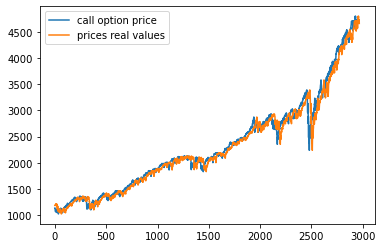

In [ ]:
plt.plot(call_prices[:,2], label='call option price')
plt.plot(SPX_price.Close.values, label='prices real values')
plt.legend()

In [ ]:
call_prices = np.insert( call_prices, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )

for k in range(Npaths):
    col      = 'call_sim_' + str( k )
    UX1[col] = pd.Series( call_prices[:,k], index = UX1.index)

UX1['mean_call'] = ( UX1.loc[:, ['call_sim_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )

/tmp/ipykernel_82674/3350147036.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  UX1[col] = pd.Series( call_prices[:,k], index = UX1.index)


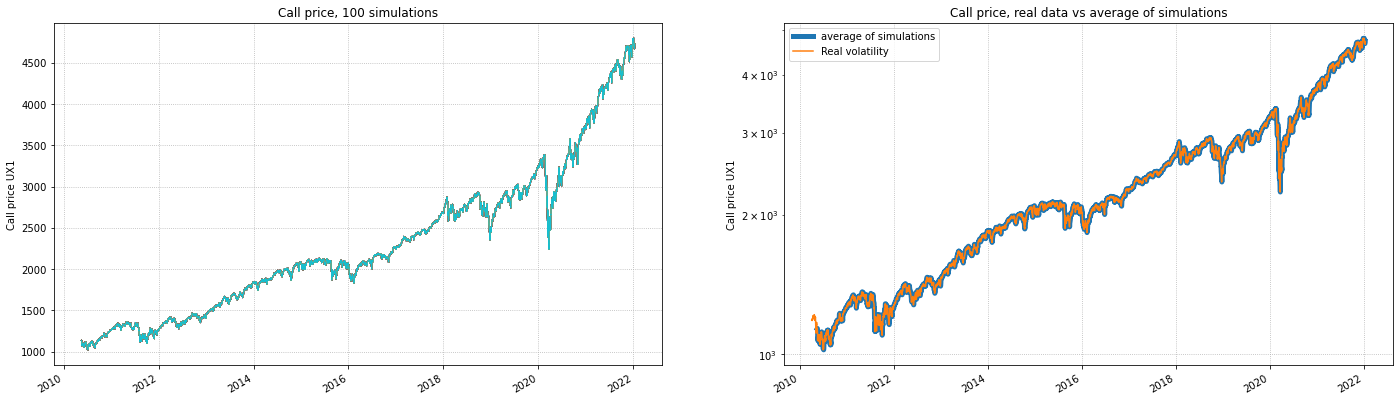

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    col = 'call_sim_' + str(k)
    ax[0].plot(UX1.index, UX1[col], label='', lw=1)
#ax[0].plot(UX2.index, UX2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
#ax[0].legend(loc='best')
ax[0].set_title('Call price, ' + str(Npaths) + ' simulations')
ax[0].set_ylabel('Call price UX1')

ax[1].plot(UX1.index, UX1['mean_call'], label='average of simulations', lw=5)
ax[1].plot(UX1.index, SPX_price.Close, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Call price, real data vs average of simulations')
ax[1].set_ylabel('Call price UX1')
ax[1].set_yscale('log')

fig.autofmt_xdate()
plt.show()

<AxesSubplot:xlabel='Date'>

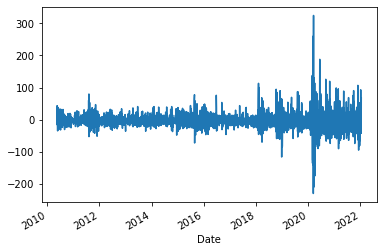

In [ ]:
a = UX1['mean_call'] - SPX_price.Close
a.plot()